<a href="https://colab.research.google.com/github/mrunallll/Covid-Cases-Flipr-Hackathon6.0/blob/master/02Covid_Task02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The time Series feature 'Foreign Visitors' can be predicted using multivariate multistep LSTM (Long Short Term Memory)

Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
#import pandas_profiling
from pandas import DataFrame
import seaborn as sns
import warnings
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(12,8)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
up=files.upload()

Saving part2-dataset.xlsx to part2-dataset.xlsx


In [3]:
foreign_visitors=pd.read_excel('part2-dataset.xlsx')

Renaming Feature columns

In [4]:
foreign_visitors.drop(foreign_visitors.index[0], inplace=True)
foreign_visitors.rename(columns={'Time Series Data': "April",
                      'Unnamed: 2'	: "May", 'Unnamed: 3'	: "June", 
                      'Unnamed: 4'	: "July", 'Unnamed: 5'	: "August"}, inplace=True)

In [5]:
foreign_visitors.head()

,City,April,May,June,July,August
1,Tuensang,1614,1946,2372,2500,2769
2,Lakshmeshwar,369179,445559,541045,572860,636502
3,Zira,140581,169665,206030,218138,242367
4,Yawal,2557179,3086249,3747597,3968032,4408916
5,Thana Bhawan,1800363,2172850,2638469,2793662,3104060


# Data Preprocessing
1. Convert all columns into float
2. Fill Missing Values
3. Transpose & drop Cities column (not required)

In [6]:
#Converting to float
convert_dict = {'April':float,
'May':float,
'June':float,
'July': float,
'August':float} 
foreign_visitors = foreign_visitors.astype(convert_dict) 

In [7]:
print(foreign_visitors.dtypes)

City       object
April     float64
May       float64
June      float64
July      float64
August    float64
dtype: object


#Missing Values
It is extremely important to fill right missing values.

After extensive data exploration, it is observed that cities that belong to the same state have same number of visitors in a month.

So, cities had to be grouped according to states to fill the missing values

Since states feature was not available in Foreign Visitors Test data, the cities are grouped by August values since there are 28 distint values for August.

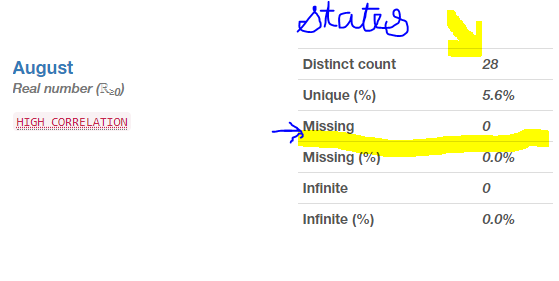

So, the August data is used as refernce for States and groupby August

In [8]:
foreign_visitors["April"] = foreign_visitors.groupby("August").transform(lambda x: x.fillna(x.median()))["April"]
foreign_visitors["May"] = foreign_visitors.groupby("August").transform(lambda x: x.fillna(x.median()))["May"]
foreign_visitors["June"] = foreign_visitors.groupby("August").transform(lambda x: x.fillna(x.median()))["June"]
foreign_visitors["July"] = foreign_visitors.groupby("August").transform(lambda x: x.fillna(x.median()))["July"]

In [9]:
foreign_visitors.isnull().sum()

City      0
April     0
May       0
June      0
July      0
August    0
dtype: int64

In [15]:
foreign_visitors.head(30)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501
April,1614,369179,140581,2.55718e+06,1.80036e+06,369179,2.55718e+06,73133,369179,855688,863918,2.55718e+06,3317,97323,2.55718e+06,369179,369179,244400,244400,137963,369179,855688,33977,2.55718e+06,855688,369179,2.71714e+06,1.80036e+06,1614,165292,369179,855688,855688,2.55718e+06,2.55718e+06,140581,1.80036e+06,855688,244400,855688,...,61420,61420,61420,855688,61420,61420,61420,38851,61420,137963,61420,61420,61420,61420,140581,61420,863918,61420,369179,244400,61420,61420,137963,2.55718e+06,535775,61420,61420,61420,61420,175816,855688,61420,61420,61420,61420,61420,61420,61420,61420,1.80036e+06
May,1946,445559,169665,3.08625e+06,2.17285e+06,445559,3.08625e+06,88263,445559,1.03273e+06,1.04266e+06,3.08625e+06,4002,117458,3.08625e+06,445559,445559,294964,294964,166506,445559,1.03273e+06,41006,3.08625e+06,1.03273e+06,445559,3.2793e+06,2.17285e+06,1946,199489,445559,1.03273e+06,1.03273e+06,3.08625e+06,3.08625e+06,169665,2.17285e+06,1.03273e+06,294964,1.03273e+06,...,74125,74125,74125,1.03273e+06,74125,74125,74125,46888,74125,166506,74125,74125,74125,74125,169665,74125,1.04266e+06,74125,445559,294964,74125,74125,166506,3.08625e+06,646624,74125,74125,74125,74125,212191,1.03273e+06,74125,74125,74125,74125,74125,74125,74125,74125,2.17285e+06
June,2372,541045,206030,3.7476e+06,2.63847e+06,541045,3.7476e+06,107184,541045,1.25403e+06,1.26609e+06,3.7476e+06,4867,142635,3.7476e+06,541045,541045,358178,358178,202194,541045,1.25403e+06,49801,3.7476e+06,1.25403e+06,541045,3.98202e+06,2.63847e+06,2372,242245,541045,1.25403e+06,1.25403e+06,3.7476e+06,3.7476e+06,206030,2.63847e+06,1.25403e+06,358178,1.25403e+06,...,90018,90018,90018,1.25403e+06,90018,90018,90018,56943,90018,202194,90018,90018,90018,90018,206030,90018,1.26609e+06,90018,541045,358178,90018,90018,202194,3.7476e+06,785194,90018,90018,90018,90018,257668,1.25403e+06,90018,90018,90018,90018,90018,90018,90018,90018,2.63847e+06
July,2500,572860,218138,3.96803e+06,2.79366e+06,572860,3.96803e+06,113478,572860,1.32779e+06,1.34056e+06,3.96803e+06,5143,151015,3.96803e+06,572860,572860,379237,379237,214077,572860,1.32779e+06,52719,3.96803e+06,1.32779e+06,572860,4.21624e+06,2.79366e+06,2500,256484,572860,1.32779e+06,1.32779e+06,3.96803e+06,3.96803e+06,218138,2.79366e+06,1.32779e+06,379237,1.32779e+06,...,95302,95302,95302,1.32779e+06,95302,95302,95302,60282,95302,214077,95302,95302,95302,95302,218138,95302,1.34056e+06,95302,572860,379237,95302,95302,214077,3.96803e+06,831371,95302,95302,95302,95302,272814,1.32779e+06,95302,95302,95302,95302,95302,95302,95302,95302,2.79366e+06
August,2769,636502,242367,4.40892e+06,3.10406e+06,636502,4.40892e+06,126078,636502,1.47531e+06,1.4895e+06,4.40892e+06,5705,167785,4.40892e+06,636502,636502,421365,421365,237854,636502,1.47531e+06,58568,4.40892e+06,1.47531e+06,636502,4.68471e+06,3.10406e+06,2769,284973,636502,1.47531e+06,1.47531e+06,4.40892e+06,4.40892e+06,242367,3.10406e+06,1.47531e+06,421365,1.47531e+06,...,105882,105882,105882,1.47531e+06,105882,105882,105882,66971,105882,237854,105882,105882,105882,105882,242367,105882,1.4895e+06,105882,636502,421365,105882,105882,237854,4.40892e+06,923737,105882,105882,105882,105882,303118,1.47531e+06,105882,105882,105882,105882,105882,105882,105882,105882,3.10406e+06


In [11]:
foreign_visitors = foreign_visitors.transpose()
foreign_visitors.drop(foreign_visitors.index[0], inplace=True)

#Using LSTM (Long Short Term Memory)
to predict September and October Foreign visitors

In [72]:
# multivariate multi-step lstm 
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
 

In [73]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 

In [77]:
# defining input sequence
in_seq0 = array(foreign_visitors.iloc[0, :].values)
in_seq1 = array(foreign_visitors.iloc[1, :].values)
in_seq2 = array(foreign_visitors.iloc[2, :].values)
in_seq3 = array(foreign_visitors.iloc[3, :].values)
in_seq4 = array(foreign_visitors.iloc[4, :].values)

out_seq = array([in_seq0[i]+in_seq1[i]+in_seq2[i]+in_seq3[i]+in_seq4[i] for i in range(len(in_seq0))])
out_seq = out_seq//(3.4)

#[rows, columns] structure
in_seq0 = in_seq0.reshape((len(in_seq0), 1))
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))

out_seq = out_seq.reshape((len(out_seq), 1))


# horizontally stack columns
dataset = hstack((in_seq0, in_seq1, in_seq2, in_seq3, in_seq4, out_seq))


In [ ]:
# choosing  number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

n_features = X.shape[2]

In [ ]:
#Model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fitting model
model.fit(X, y, epochs=300, verbose=0)

In [78]:
pd.DataFrame(dataset)

,0,1,2,3,4,5
0,1614,1946,2372,2500,2769,3294
1,369179,445559,541045,572860,636502,754454
2,140581,169665,206030,218138,242367,287288
3,2.55718e+06,3.08625e+06,3.7476e+06,3.96803e+06,4.40892e+06,5.22587e+06
4,1.80036e+06,2.17285e+06,2.63847e+06,2.79366e+06,3.10406e+06,3.67924e+06
...,...,...,...,...,...,...
496,61420,74125,90018,95302,105882,125513
497,61420,74125,90018,95302,105882,125513
498,61420,74125,90018,95302,105882,125513
499,61420,74125,90018,95302,105882,125513


#Important to note
Since a multi-step multiple output LSTM is not providing accurate output for October, LSTM is first made to predict for September, the dataset is downloaded and again fed to LSTM for calculating Foregin visitors for October

In [81]:
from google.colab import files
up=files.upload()

Saving part02-a.xlsx to part02-a.xlsx


In [82]:
foreign_visitors=pd.read_excel('part02-a.xlsx')

In [86]:
#foreign_visitors.drop(columns=['Unnamed: 0'], inplace=True)
foreign_visitors.rename(columns={0: "April",
                      1	: "May", 2	: "June", 
                      3	: "July", "September"	: "August", 5	: "September"}, inplace=True)

In [88]:
foreign_visitors=foreign_visitors.transpose()

In [98]:
# define input sequence
in_seq0 = array(foreign_visitors.iloc[0, :].values)
in_seq1 = array(foreign_visitors.iloc[1, :].values)
in_seq2 = array(foreign_visitors.iloc[2, :].values)
in_seq3 = array(foreign_visitors.iloc[3, :].values)
in_seq4 = array(foreign_visitors.iloc[4, :].values)
in_seq5 = array(foreign_visitors.iloc[5, :].values)

out_seq = array([in_seq0[i]+in_seq1[i]+in_seq2[i]+in_seq3[i]+in_seq4[i]+in_seq5[i] for i in range(len(in_seq0))])
out_seq = out_seq//(3.9)


# convert to [rows, columns] structure
in_seq0 = in_seq0.reshape((len(in_seq0), 1))
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))


out_seq = out_seq.reshape((len(out_seq), 1))
#out_seq2 = out_seq2.reshape((len(out_seq2), 1))


# horizontally stack columns
dataset = hstack((in_seq0, in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, out_seq))


In [58]:
# choosing a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

n_features = X.shape[2]

In [60]:
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
#model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=300, verbose=0)

In [99]:
pd.DataFrame(dataset)

,0,1,2,3,4,5,6
0,1614.0,1946.0,2372.0,2500.0,2769.0,3294.0,3716.0
1,369179.0,445559.0,541045.0,572860.0,636502.0,754454.0,851179.0
2,140581.0,169665.0,206030.0,218138.0,242367.0,287288.0,324120.0
3,2557179.0,3086249.0,3747597.0,3968032.0,4408916.0,5225874.0,5895858.0
4,1800363.0,2172850.0,2638469.0,2793662.0,3104060.0,3679236.0,4150933.0
...,...,...,...,...,...,...,...
496,61420.0,74125.0,90018.0,95302.0,105882.0,125513.0,141605.0
497,61420.0,74125.0,90018.0,95302.0,105882.0,125513.0,141605.0
498,61420.0,74125.0,90018.0,95302.0,105882.0,125513.0,141605.0
499,61420.0,74125.0,90018.0,95302.0,105882.0,125513.0,141605.0


In [100]:
output=pd.DataFrame(dataset)

In [70]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [101]:
output.to_csv('october.csv')
!cp october.csv "drive/My Drive/"

#Regression Model Training
In the training data, foreign visitors is replaces by LSTM predicted october foreign visitors, and fed to the same Random Forest Model

In [ ]:
x_train=train_data.iloc[:, 1:14].values
y_train=train_data.iloc[:, -1].values
#Train data is same, just replaced Foreign visitors with October foreign visitors

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 600, random_state = 0) 
rf.fit(x_train, y_train)
y_pred = rf.predict(test_data)

In [ ]:
from sklearn.model_selection import cross_val_score
r2 = cross_val_score(ran, x_train, y_train, cv=10, scoring='r2')
r2_mean=np.mean(r2)
print(r2_mean)